In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange

In [2]:
os.chdir('../')

In [3]:
%%capture
from nutrition_labels.grant_tagger import GrantTagger

In [4]:
data = pd.read_csv('data/processed/training_data.csv')

(array([  6.,   2.,   2.,   9.,  12.,  22.,  30.,  65., 182., 438., 161.,
         52.,  35.,  18.,  14.,   2.,   7.,   2.,   6.,   8.,   2.,   0.,
          2.,   5.,   3.,   2.,   3.,   0.,   3.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([ 102.  ,  234.62,  367.24,  499.86,  632.48,  765.1 ,  897.72,
        1030.34, 1162.96, 1295.58, 1428.2 , 1560.82, 1693.44, 1826.06,
        1958.68, 2091.3 , 2223.92, 2356.54, 2489.16, 2621.78, 2754.4 ,
        2887.02, 3019.64, 3152.26, 3284.88, 3417.5 , 3550.12, 3682.74,
        3815.36, 3947.98, 4080.6 , 4213.22, 4345.84, 4478.46, 4611.08,
        4743.7 , 4876.32, 5008.94, 5141.56, 5274.18, 5406.8 , 5539.42,
        5672.04, 5804.66, 5937.28, 6069.9 , 6202.52, 6335.14, 6467.76,
        6600.38, 6733.  ]),
 <BarContainer object of 50 artists>)

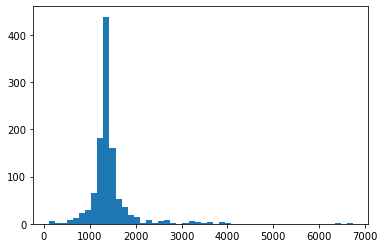

In [5]:
plt.hist(data['Description'].apply(len), bins=50)

In [6]:
len([d for d in data['Description'] if len(d)<500])

10

In [7]:
def run_experiment(relevant_sample_ratio_range, num_repeats, vectorizer_type,model_type = 'naive_bayes',bert_type = 'bert'):
    experiments_results = []
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type,
                bert_type = bert_type
            )
    X_vect,y = grant_tagger.transform(data)
    for n in relevant_sample_ratio_range:
        average_results_train = None
        average_results_test = None
        for i in range(0, num_repeats):
            # Take the average of 5 runs

            X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                relevant_sample_ratio = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
            grant_tagger.fit(X_train, y_train)
            results_train = grant_tagger.evaluate(X_train, y_train, print_results=False, average='weighted')
            results_test = grant_tagger.evaluate(X_test, y_test, print_results=False, average='weighted')
            if average_results_train: # will be the same for test too
                for key in average_results_train.keys(): # will be the same for test too
                    average_results_train[key] += results_train[key]
                    average_results_test[key] += results_test[key]
            else:
                average_results_train = results_train
                average_results_test = results_test
        average_results_train = {key: value/num_repeats for key, value in average_results_train.items()}
        average_results_test = {key: value/num_repeats for key, value in average_results_test.items()}
        results_dict = {'relevant_sample_ratio': n}
        for key, value in average_results_train.items():
            results_dict[key+'_train'] = value
        for key, value in average_results_test.items():
            results_dict[key+'_test'] = value
        experiments_results.append(results_dict)
        
    return experiments_results

In [8]:
def plot_results(experiments_results_df):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    experiments_results_df.plot(kind='line', x='relevant_sample_ratio', y='accuracy_train',ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='relevant_sample_ratio', y='accuracy_test', color='red', ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='relevant_sample_ratio', y='f1_train',ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='relevant_sample_ratio', y='f1_test', color='red', ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='relevant_sample_ratio', y='precision_score_train',ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='relevant_sample_ratio', y='precision_score_test', color='red', ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='relevant_sample_ratio', y='recall_score_train',ax=ax4, marker='.')
    experiments_results_df.plot(kind='line', x='relevant_sample_ratio', y='recall_score_test', color='red', ax=ax4, marker='.')
    # fig.savefig(f'relevant_sample_ratio_{num_repeats}reps_{vectorizer_type}.png')
    # plt.close(fig)
    plt.show()

In [9]:
count_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='count'
)

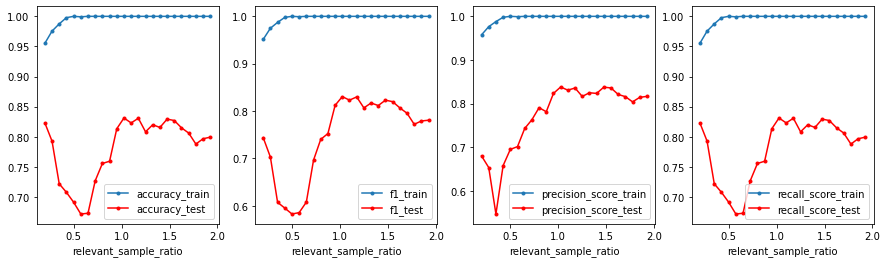

In [10]:
experiments_results_df = pd.DataFrame(count_experiments_results)
plot_results(experiments_results_df)

In [11]:
tfidf_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='tfidf'
)

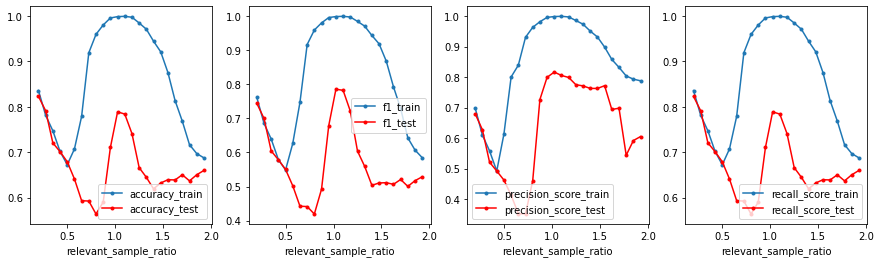

In [12]:
experiments_results_df = pd.DataFrame(tfidf_experiments_results)
plot_results(experiments_results_df)

In [13]:
print(len(data.loc[data['Relevance code'] == 1]))
print(len(data.loc[data['Relevance code'] == 0]))

214
883


## Explore all the results of those with good parameters

In [14]:
def test_setting(data, vectorizer_type, n, model_type = 'naive_bayes',bert_type = 'bert'):
    i = 4
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type,
                bert_type = bert_type
            )
    X_vect,y = grant_tagger.transform(data)
    X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                relevant_sample_ratio = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
    grant_tagger.fit(X_train, y_train)
    results_train = grant_tagger.evaluate(X_train, y_train, average='weighted')
    results_test = grant_tagger.evaluate(X_test, y_test, average='weighted')

In [15]:
test_setting(data, 'tfidf', 0.2)

{'accuracy': 0.8697916666666666, 'f1': 0.8092212163416899, 'precision_score': 0.7565375434027777, 'recall_score': 0.8697916666666666}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.87      1.00      0.93       167

    accuracy                           0.87       192
   macro avg       0.43      0.50      0.47       192
weighted avg       0.76      0.87      0.81       192

              predicted tag 0  predicted tag 1
actual tag 0                0               25
actual tag 1                0              167
{'accuracy': 0.7230769230769231, 'f1': 0.6068681318681318, 'precision_score': 0.5228402366863905, 'recall_score': 0.7230769230769231}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.72      1.00      0.84        47

    accuracy                           0.72        65
   macro avg       0.36      0.50      0.42   

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
test_setting(data, 'tfidf', 1.1)

{'accuracy': 1.0, 'f1': 1.0, 'precision_score': 1.0, 'recall_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      1.00      1.00       155

    accuracy                           1.00       336
   macro avg       1.00      1.00      1.00       336
weighted avg       1.00      1.00      1.00       336

              predicted tag 0  predicted tag 1
actual tag 0              181                0
actual tag 1                0              155
{'accuracy': 0.7699115044247787, 'f1': 0.7630162241887906, 'precision_score': 0.8208688427598534, 'recall_score': 0.7699115044247787}
              precision    recall  f1-score   support

           0       0.68      0.96      0.80        54
           1       0.95      0.59      0.73        59

    accuracy                           0.77       113
   macro avg       0.82      0.78      0.76       113
weighted avg       0.82      0.77      0.76       11

In [17]:
test_setting(data, 'count', 0.2)

{'accuracy': 0.9322916666666666, 'f1': 0.92166527117896, 'precision_score': 0.937181712962963, 'recall_score': 0.9322916666666666}
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        25
           1       0.93      1.00      0.96       167

    accuracy                           0.93       192
   macro avg       0.96      0.74      0.81       192
weighted avg       0.94      0.93      0.92       192

              predicted tag 0  predicted tag 1
actual tag 0               12               13
actual tag 1                0              167
{'accuracy': 0.7230769230769231, 'f1': 0.6068681318681318, 'precision_score': 0.5228402366863905, 'recall_score': 0.7230769230769231}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.72      1.00      0.84        47

    accuracy                           0.72        65
   macro avg       0.36      0.50      0.42      

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
test_setting(data, 'count', 1.625)

{'accuracy': 1.0, 'f1': 1.0, 'precision_score': 1.0, 'recall_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       162

    accuracy                           1.00       421
   macro avg       1.00      1.00      1.00       421
weighted avg       1.00      1.00      1.00       421

              predicted tag 0  predicted tag 1
actual tag 0              259                0
actual tag 1                0              162
{'accuracy': 0.8085106382978723, 'f1': 0.7981488797336193, 'precision_score': 0.8163101450937662, 'recall_score': 0.8085106382978723}
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        89
           1       0.86      0.58      0.69        52

    accuracy                           0.81       141
   macro avg       0.82      0.76      0.78       141
weighted avg       0.82      0.81      0.80       14

## Testing Bert Vectorizer


Bert and Naive Bayes model


In [19]:
%%capture
bert_bayes_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert'
)


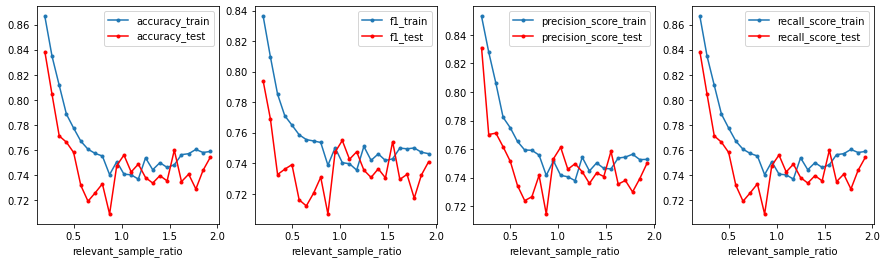

In [20]:
experiments_results_df = pd.DataFrame(bert_bayes_experiments_results)
plot_results(experiments_results_df)

Bert and SVM model


In [21]:
%%capture
bert_svm_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='SVM'
)


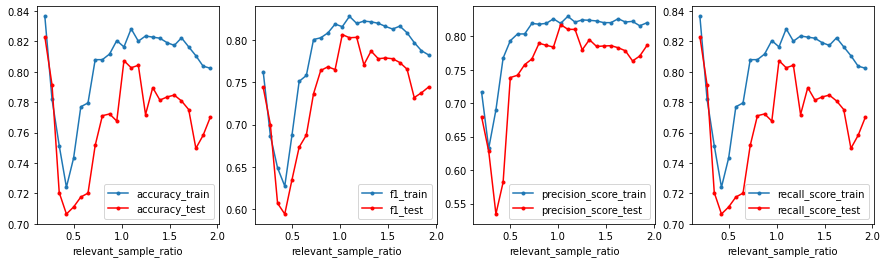

In [22]:
experiments_results_df = pd.DataFrame(bert_svm_experiments_results)
plot_results(experiments_results_df)

Bert and Logistic regression model


In [23]:
%%capture
bert_logreg_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='log_reg'
)


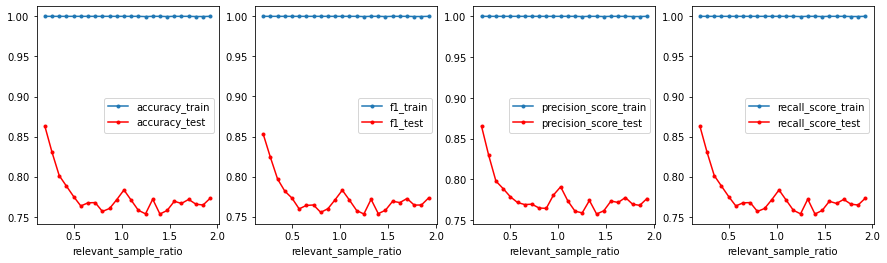

In [24]:
experiments_results_df = pd.DataFrame(bert_logreg_experiments_results)
plot_results(experiments_results_df)

## Exploring Bert Results with good parameters 

In [25]:
test_setting(data, 'bert', 0.2)

{'accuracy': 0.8645833333333334, 'f1': 0.8232697740112994, 'precision_score': 0.814895276292335, 'recall_score': 0.8645833333333334}
              precision    recall  f1-score   support

           0       0.40      0.08      0.13        25
           1       0.88      0.98      0.93       167

    accuracy                           0.86       192
   macro avg       0.64      0.53      0.53       192
weighted avg       0.81      0.86      0.82       192

              predicted tag 0  predicted tag 1
actual tag 0                2               23
actual tag 1                3              164
{'accuracy': 0.7384615384615385, 'f1': 0.6414852099062625, 'precision_score': 0.8079326923076923, 'recall_score': 0.7384615384615385}
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.73      1.00      0.85        47

    accuracy                           0.74        65
   macro avg       0.87      0.53      0.48    

In [26]:
test_setting(data, 'bert', 1.775)

{'accuracy': 0.755056179775281, 'f1': 0.750733666314317, 'precision_score': 0.7500013525792094, 'recall_score': 0.755056179775281}
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       286
           1       0.68      0.59      0.63       159

    accuracy                           0.76       445
   macro avg       0.73      0.72      0.72       445
weighted avg       0.75      0.76      0.75       445

              predicted tag 0  predicted tag 1
actual tag 0              242               44
actual tag 1               65               94
{'accuracy': 0.7315436241610739, 'f1': 0.7212716238066759, 'precision_score': 0.725241447045343, 'recall_score': 0.7315436241610739}
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        94
           1       0.68      0.51      0.58        55

    accuracy                           0.73       149
   macro avg       0.72      0.69      0.69       

In [27]:
test_setting(data, 'bert', 0.5,'SVM')

{'accuracy': 0.6916666666666667, 'f1': 0.5875541125541125, 'precision_score': 0.7352564102564102, 'recall_score': 0.6916666666666667}
              precision    recall  f1-score   support

           0       0.83      0.06      0.12        78
           1       0.69      0.99      0.81       162

    accuracy                           0.69       240
   macro avg       0.76      0.53      0.47       240
weighted avg       0.74      0.69      0.59       240

              predicted tag 0  predicted tag 1
actual tag 0                5               73
actual tag 1                1              161
{'accuracy': 0.6666666666666666, 'f1': 0.5558565213822539, 'precision_score': 0.7805907172995781, 'recall_score': 0.6666666666666666}
              precision    recall  f1-score   support

           0       1.00      0.07      0.13        29
           1       0.66      1.00      0.79        52

    accuracy                           0.67        81
   macro avg       0.83      0.53      0.46   

In [28]:
test_setting(data, 'bert', 1.625,'SVM')

{'accuracy': 0.8266033254156769, 'f1': 0.8204017009550482, 'precision_score': 0.8322292455978485, 'recall_score': 0.8266033254156769}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       259
           1       0.87      0.65      0.74       162

    accuracy                           0.83       421
   macro avg       0.84      0.79      0.81       421
weighted avg       0.83      0.83      0.82       421

              predicted tag 0  predicted tag 1
actual tag 0              243               16
actual tag 1               57              105
{'accuracy': 0.8085106382978723, 'f1': 0.8052240000474262, 'precision_score': 0.8062697005516154, 'recall_score': 0.8085106382978723}
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        89
           1       0.78      0.67      0.72        52

    accuracy                           0.81       141
   macro avg       0.80      0.78      0.79   

## Testing Scibert Vectorizer


Scibert and Naive Bayes model


In [29]:
%%capture
scibert_bayes_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', bert_type= 'scibert'
)


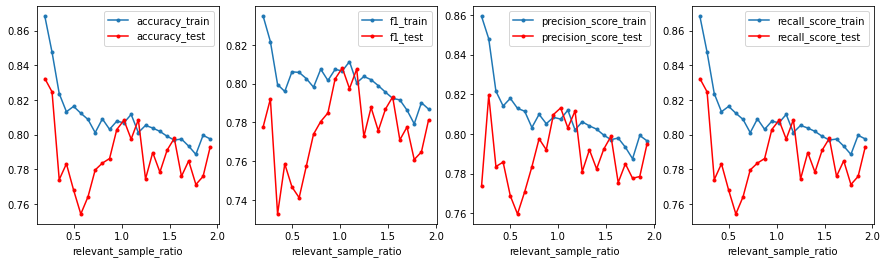

In [30]:
experiments_results_df = pd.DataFrame(scibert_bayes_experiments_results)
plot_results(experiments_results_df)

Scibert and SVM model


In [31]:
%%capture
scibert_svm_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='SVM', bert_type= 'scibert'
)


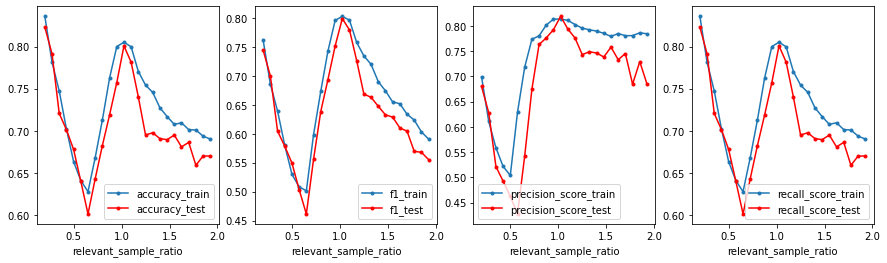

In [32]:
experiments_results_df = pd.DataFrame(scibert_svm_experiments_results)
plot_results(experiments_results_df)

Scibert and Logistic regression model


In [33]:
%%capture
scibert_logreg_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='log_reg', bert_type= 'scibert'
)


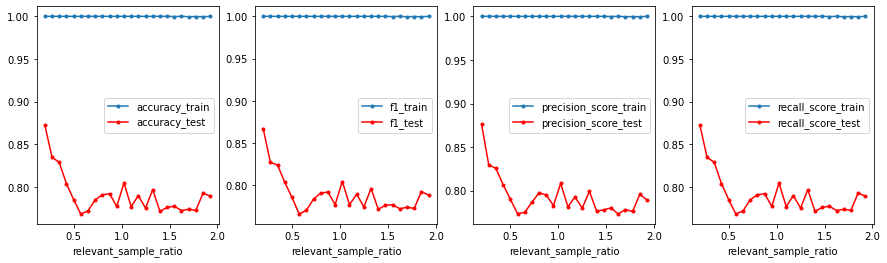

In [34]:
experiments_results_df = pd.DataFrame(scibert_logreg_experiments_results)
plot_results(experiments_results_df)

## Exploring Scibert Results with good parameters

Scibert and Naive Bayes

In [35]:
test_setting(data, 'bert', 1.625, bert_type = 'scibert')

{'accuracy': 0.8147268408551069, 'f1': 0.8087497611498364, 'precision_score': 0.8177953519306672, 'recall_score': 0.8147268408551069}
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       259
           1       0.84      0.64      0.73       162

    accuracy                           0.81       421
   macro avg       0.82      0.78      0.79       421
weighted avg       0.82      0.81      0.81       421

              predicted tag 0  predicted tag 1
actual tag 0              239               20
actual tag 1               58              104
{'accuracy': 0.7801418439716312, 'f1': 0.7775933970562503, 'precision_score': 0.7771238871284141, 'recall_score': 0.7801418439716312}
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        89
           1       0.72      0.65      0.69        52

    accuracy                           0.78       141
   macro avg       0.77      0.75      0.76   

Scibert and SVM

In [36]:
test_setting(data, 'bert', 0.2, 'SVM',bert_type = 'scibert')

{'accuracy': 0.8697916666666666, 'f1': 0.8092212163416899, 'precision_score': 0.7565375434027777, 'recall_score': 0.8697916666666666}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.87      1.00      0.93       167

    accuracy                           0.87       192
   macro avg       0.43      0.50      0.47       192
weighted avg       0.76      0.87      0.81       192

              predicted tag 0  predicted tag 1
actual tag 0                0               25
actual tag 1                0              167
{'accuracy': 0.7230769230769231, 'f1': 0.6068681318681318, 'precision_score': 0.5228402366863905, 'recall_score': 0.7230769230769231}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.72      1.00      0.84        47

    accuracy                           0.72        65
   macro avg       0.36      0.50      0.42   

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
test_setting(data, 'bert', 1.175,'SVM', bert_type = 'scibert')

{'accuracy': 0.7097701149425287, 'f1': 0.6689496441983172, 'precision_score': 0.8008373491540126, 'recall_score': 0.7097701149425287}
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       196
           1       0.98      0.34      0.51       152

    accuracy                           0.71       348
   macro avg       0.82      0.67      0.65       348
weighted avg       0.80      0.71      0.67       348

              predicted tag 0  predicted tag 1
actual tag 0              195                1
actual tag 1              100               52
{'accuracy': 0.6324786324786325, 'f1': 0.5962633409929107, 'precision_score': 0.7488831961542414, 'recall_score': 0.6324786324786325}
              precision    recall  f1-score   support

           0       0.56      0.96      0.71        55
           1       0.91      0.34      0.49        62

    accuracy                           0.63       117
   macro avg       0.74      0.65      0.60   

Scibert and log reg

In [38]:
test_setting(data, 'bert', 0.275,'log_reg', bert_type = 'scibert')

{'accuracy': 1.0, 'f1': 1.0, 'precision_score': 1.0, 'recall_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       162

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204

              predicted tag 0  predicted tag 1
actual tag 0               42                0
actual tag 1                0              162
{'accuracy': 0.8260869565217391, 'f1': 0.8055422838031534, 'precision_score': 0.8196457326892109, 'recall_score': 0.8260869565217391}
              precision    recall  f1-score   support

           0       0.78      0.41      0.54        17
           1       0.83      0.96      0.89        52

    accuracy                           0.83        69
   macro avg       0.81      0.69      0.72        69
weighted avg       0.82      0.83      0.81        6

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [39]:
test_setting(data, 'bert', 1.7,'log_reg', bert_type = 'scibert')

{'accuracy': 1.0, 'f1': 1.0, 'precision_score': 1.0, 'recall_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       167

    accuracy                           1.00       433
   macro avg       1.00      1.00      1.00       433
weighted avg       1.00      1.00      1.00       433

              predicted tag 0  predicted tag 1
actual tag 0              266                0
actual tag 1                0              167
{'accuracy': 0.7655172413793103, 'f1': 0.7667510961014339, 'precision_score': 0.7682852451325358, 'recall_score': 0.7655172413793103}
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        98
           1       0.63      0.66      0.65        47

    accuracy                           0.77       145
   macro avg       0.73      0.74      0.74       145
weighted avg       0.77      0.77      0.77       14

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test_setting(data, 'bert', 1.7,'log_reg', bert_type = 'scibert')

Scibert and Naive Bayes

In [40]:
test_setting(data, 'bert', 1.625, bert_type = 'scibert')

{'accuracy': 0.8147268408551069, 'f1': 0.8087497611498364, 'precision_score': 0.8177953519306672, 'recall_score': 0.8147268408551069}
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       259
           1       0.84      0.64      0.73       162

    accuracy                           0.81       421
   macro avg       0.82      0.78      0.79       421
weighted avg       0.82      0.81      0.81       421

              predicted tag 0  predicted tag 1
actual tag 0              239               20
actual tag 1               58              104
{'accuracy': 0.7801418439716312, 'f1': 0.7775933970562503, 'precision_score': 0.7771238871284141, 'recall_score': 0.7801418439716312}
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        89
           1       0.72      0.65      0.69        52

    accuracy                           0.78       141
   macro avg       0.77      0.75      0.76   

Scibert and SVM

In [41]:
test_setting(data, 'bert', 0.2, 'SVM',bert_type = 'scibert')

{'accuracy': 0.8697916666666666, 'f1': 0.8092212163416899, 'precision_score': 0.7565375434027777, 'recall_score': 0.8697916666666666}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.87      1.00      0.93       167

    accuracy                           0.87       192
   macro avg       0.43      0.50      0.47       192
weighted avg       0.76      0.87      0.81       192

              predicted tag 0  predicted tag 1
actual tag 0                0               25
actual tag 1                0              167
{'accuracy': 0.7230769230769231, 'f1': 0.6068681318681318, 'precision_score': 0.5228402366863905, 'recall_score': 0.7230769230769231}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.72      1.00      0.84        47

    accuracy                           0.72        65
   macro avg       0.36      0.50      0.42   

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
test_setting(data, 'bert', 1.175,'SVM', bert_type = 'scibert')

{'accuracy': 0.7097701149425287, 'f1': 0.6689496441983172, 'precision_score': 0.8008373491540126, 'recall_score': 0.7097701149425287}
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       196
           1       0.98      0.34      0.51       152

    accuracy                           0.71       348
   macro avg       0.82      0.67      0.65       348
weighted avg       0.80      0.71      0.67       348

              predicted tag 0  predicted tag 1
actual tag 0              195                1
actual tag 1              100               52
{'accuracy': 0.6324786324786325, 'f1': 0.5962633409929107, 'precision_score': 0.7488831961542414, 'recall_score': 0.6324786324786325}
              precision    recall  f1-score   support

           0       0.56      0.96      0.71        55
           1       0.91      0.34      0.49        62

    accuracy                           0.63       117
   macro avg       0.74      0.65      0.60   

Scibert and log reg

In [43]:
test_setting(data, 'bert', 0.275,'log_reg', bert_type = 'scibert')

{'accuracy': 1.0, 'f1': 1.0, 'precision_score': 1.0, 'recall_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       162

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204

              predicted tag 0  predicted tag 1
actual tag 0               42                0
actual tag 1                0              162
{'accuracy': 0.8260869565217391, 'f1': 0.8055422838031534, 'precision_score': 0.8196457326892109, 'recall_score': 0.8260869565217391}
              precision    recall  f1-score   support

           0       0.78      0.41      0.54        17
           1       0.83      0.96      0.89        52

    accuracy                           0.83        69
   macro avg       0.81      0.69      0.72        69
weighted avg       0.82      0.83      0.81        6

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [44]:
test_setting(data, 'bert', 1.7,'log_reg', bert_type = 'scibert')

{'accuracy': 1.0, 'f1': 1.0, 'precision_score': 1.0, 'recall_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       167

    accuracy                           1.00       433
   macro avg       1.00      1.00      1.00       433
weighted avg       1.00      1.00      1.00       433

              predicted tag 0  predicted tag 1
actual tag 0              266                0
actual tag 1                0              167
{'accuracy': 0.7655172413793103, 'f1': 0.7667510961014339, 'precision_score': 0.7682852451325358, 'recall_score': 0.7655172413793103}
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        98
           1       0.63      0.66      0.65        47

    accuracy                           0.77       145
   macro avg       0.73      0.74      0.74       145
weighted avg       0.77      0.77      0.77       14

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
